# Setup + Loading Data

In [1]:
# Make sure that virtual environment is working

import sys
print("Python executable:", sys.executable)

Python executable: /opt/homebrew/Caskroom/miniforge/base/envs/hula-by-reqs/bin/python


In [2]:
# Importing packages

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import utilities_visualization
from process_movella import load_movella, get_position, lowpass_filter
from utilities_hula_hoop import get_steady_hooping_interval, get_fixed_frame_acceleration, offset_hoop_sensor, estimate_period
from utilities_hula_hoop import plot_PCA_modes, plot_PCA_FFT
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FFMpegWriter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

In [3]:
# Defining input and output directory

# IN_DIR = Path("/Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/experiments/Hula Hoop/2025-09-03 Experiment 5/2025-09-03 Euler Angles/")
IN_DIR = Path("uploads/2025-09-03 Experiment 5/2025-09-03 Euler Angles/")
OUT_DIR = Path("out")

# make the output directory if it does not exist
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

In [4]:
# Constants

# Hoop specifications
d = 83./100     # m, hoop diameter
r = d/2         # m, hoop radius
m = 0.25        # kg, mass of hoop

# Gravity
g = 9.81        # m/s^2, gravitational acceleration

# Time setup
f = 120         # Hz, sampling frequency
dt = 1 / f      # s, sample duration

# Inertias in corotational basis
Ixx = 0.5*m*r**2
Iyy = 0.5*m*r**2
Izz = m*r**2

In [5]:
# Reading sensor data

# OR: hoop
# OL: waist
# IB: femur
# IT: tibia
# IL: cuneiform

OR_hoop_file = IN_DIR / "OR_20250903_203926.csv"
OL_hoop_file = IN_DIR / "OL_20250903_203926.csv"
IT_hoop_file = IN_DIR / "IT_20250903_203926.csv"
IL_hoop_file = IN_DIR / "IL_20250903_203926.csv"
IB_hoop_file = IN_DIR / "IB_20250903_203926.csv"

lead_time_val = 0
OL_hoop_data = load_movella(OL_hoop_file, lead_time=lead_time_val)
OR_hoop_data = load_movella(OR_hoop_file, lead_time=lead_time_val)
IT_hoop_data = load_movella(IT_hoop_file, lead_time=lead_time_val)
IL_hoop_data = load_movella(IL_hoop_file, lead_time=lead_time_val)
IB_hoop_data = load_movella(IB_hoop_file, lead_time=lead_time_val)

time, OL_ax, OL_ay, OL_az, OL_phi, OL_theta, OL_psi, OL_wx, OL_wy, OL_wz = OL_hoop_data.T
_, OR_ax, OR_ay, OR_az, OR_phi, OR_theta, OR_psi, OR_wx, OR_wy, OR_wz = OR_hoop_data.T
_, IT_ax, IT_ay, IT_az, IT_phi, IT_theta, IT_psi, IT_wx, IT_wy, IT_wz = IT_hoop_data.T
_, IL_ax, IL_ay, IL_az, IL_phi, IL_theta, IL_psi, IL_wx, IL_wy, IL_wz = IL_hoop_data.T
_, IB_ax, IB_ay, IB_az, IB_phi, IB_theta, IB_psi, IB_wx, IB_wy, IB_wz = IB_hoop_data.T

# time step
dt = time[1]-time[0]

In [6]:
dt

np.float64(0.008333)

# Finding interval of steady hula hooping

We can detect when steady hula hoop motion is happening by looking at the psi-dot time series. psi is almost constant during steady hula hooping. You see how initially the hula hooper turns the hoop opposite to the directions at which it will rotate, then gives a high initial angular velocity. The initial angular velocity psidot will be sustained by the hoop until failure.

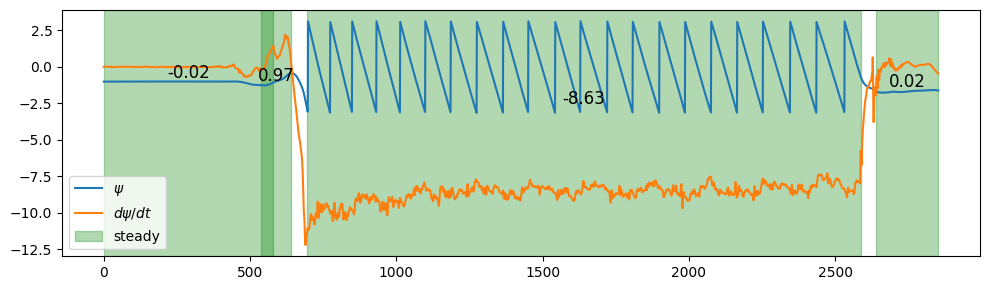

In [7]:
OR_groups, OR_averages = get_steady_hooping_interval(OR_psi, dt=dt, threshold=0.55)

In [8]:
OR_groups

[(np.int64(0), np.int64(578)),
 (np.int64(538), np.int64(640)),
 (np.int64(694), np.int64(2587)),
 (np.int64(2639), np.int64(2852))]

In [9]:
OR_averages

[np.float64(-0.016012615498467945),
 np.float64(0.9702579643553674),
 np.float64(-8.630305533323602),
 np.float64(0.024618983310848642)]

In [10]:
active_slice = np.arange(694, 2588)

# PCA on angular velocities

## without hoop

In [11]:
# Step 1: Stack and transpose
X = np.vstack([
    IB_wx[active_slice], IB_wy[active_slice], IB_wz[active_slice],
    IT_wx[active_slice], IT_wy[active_slice], IT_wz[active_slice],
    IL_wx[active_slice], IL_wy[active_slice], IL_wz[active_slice],
    ]).T

print('shape(X):')
print(np.shape(X))

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=np.shape(X)[1])
X_pca = pca.fit_transform(X_scaled)
# Get the eigenvectors (principal directions)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

X_PCA_ftc = X_pca

shape(X):
(1894, 9)


In [12]:
explained_variance_ratio

array([0.47888321, 0.285322  , 0.09546149, 0.05024735, 0.03813858,
       0.01847355, 0.01762857, 0.0105746 , 0.00527066])

## with hoop

In [13]:
# Step 1: Stack and transpose
X = np.vstack([
    IB_wx[active_slice], IB_wy[active_slice], IB_wz[active_slice],
    IT_wx[active_slice], IT_wy[active_slice], IT_wz[active_slice],
    IL_wx[active_slice], IL_wy[active_slice], IL_wz[active_slice],
    # OL_wx[active_slice], OL_wy[active_slice], OL_wz[active_slice],
    OR_wx[active_slice], OR_wy[active_slice], OR_wz[active_slice]
    ]).T

print('shape(X):')
print(np.shape(X))

# Step 2: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA
pca = PCA(n_components=np.shape(X)[1])
X_pca = pca.fit_transform(X_scaled)
# Get the eigenvectors (principal directions)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_


X_PCA_hftc = X_pca 

shape(X):
(1894, 12)


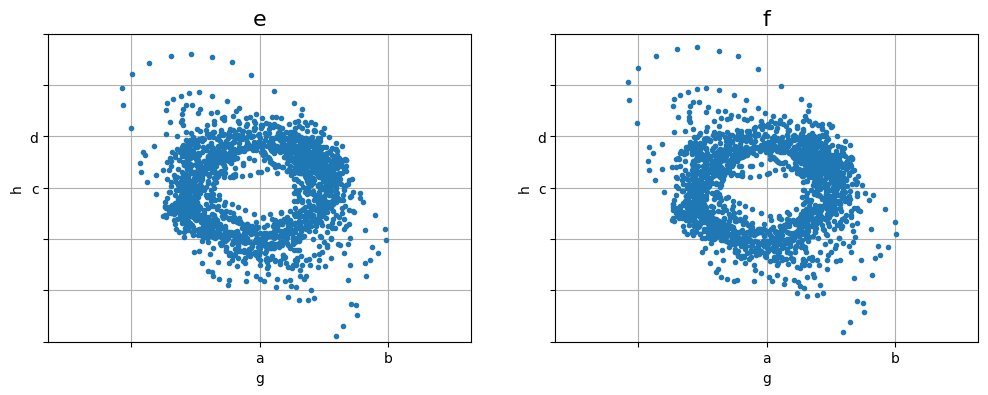

In [14]:
# plt.figure(figsize=(6, 4))
# plt.plot(X_PCA_ftc[:,0], X_PCA_ftc[:,1], '.', label="Body alone")
# plt.plot(X_PCA_hftc[:,0], X_PCA_hftc[:,1], '.', label="Hoop and body")
# plt.axis('equal')
# plt.xlabel(r"$\xi_1$")
# plt.ylabel(r"$\xi_2$")
# plt.grid(True)
# plt.legend()
# # Save if needed
# plt.savefig("pca_projections.eps", format='eps', dpi=300)
# plt.show()


fig,axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(X_PCA_ftc[:,0], X_PCA_ftc[:,1], '.')
axs[0].set_title("e",fontsize=16)
# axs[0].set_title("Body alone",fontsize=16)
axs[1].plot(X_PCA_hftc[:,0], X_PCA_hftc[:,1], '.')
axs[1].set_title("f",fontsize=16)
# axs[1].set_title("Hoop and body",fontsize=16)

for axi in axs:
    axi.grid()
    axi.axis('equal')
    axi.set_xticks(np.arange(-10,10.01,5))
    axi.set_xticklabels([None,None,'a','b',None])
    # axi.set_xticklabels([None,None,0,5,None])
    axi.set_yticks(np.arange(-6,6.1,2))
    axi.set_yticklabels([None,None,None,'c','d',None,None])
    # axi.set_yticklabels([None,None,None,0,2,None,None])
    axi.set_ylim(-6,6)
    axi.set_xlabel("g")
    # axi.set_xlabel(r"$\xi_1$",fontsize=14)
    axi.set_ylabel("h",)
    # axi.set_ylabel(r"$\xi_2$",fontsize=14)
fig.savefig("pca_projections_separate.eps", format='eps', dpi=300)
plt.show()


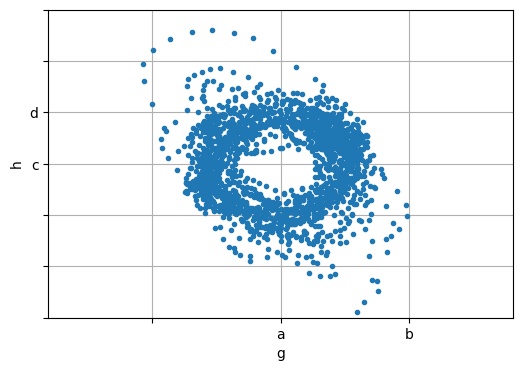

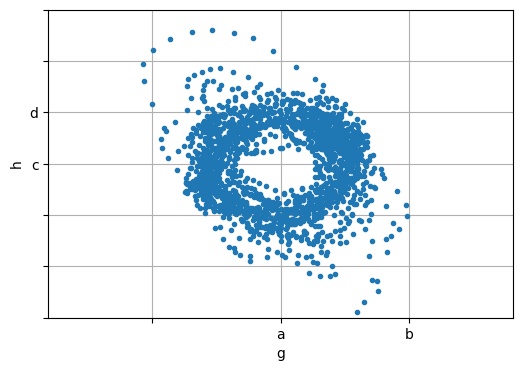

In [15]:
fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(X_PCA_ftc[:,0], X_PCA_ftc[:,1], '.')
ax.grid()
ax.axis('equal')
ax.set_xticks(np.arange(-10,10.01,5))
ax.set_xticklabels([None,None,'a','b',None])
ax.set_yticks(np.arange(-6,6.1,2))
ax.set_yticklabels([None,None,None,'c','d',None,None])
ax.set_ylim(-6,6)
ax.set_xlabel("g")
ax.set_ylabel("h")
fig.savefig("pca_projections_body.eps", format='eps', dpi=300)
plt.show()

fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(X_PCA_ftc[:,0], X_PCA_ftc[:,1], '.')
ax.grid()
ax.axis('equal')
ax.set_xticks(np.arange(-10,10.01,5))
ax.set_xticklabels([None,None,'a','b',None])
ax.set_yticks(np.arange(-6,6.1,2))
ax.set_yticklabels([None,None,None,'c','d',None,None])
ax.set_ylim(-6,6)
ax.set_xlabel("g")
ax.set_ylabel("h")
fig.savefig("pca_projections_body_hoop.eps", format='eps', dpi=300)
plt.show()